In [69]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import maxwell

Lx, Ly, Lz =10, 10, 10
epsilon =1.
sigma = 1.
N = 64
nx,ny,nz = 10,10,10
m = 1.
delta_t = 0.01
steps = 150

#转算坐标到reference box
def wrap(r,Lx,Ly,Lz):
    wrapped_r = np.array([r[0]%Lx,r[1]%Ly,r[2]%Lz])
    return wrapped_r

#minimum image distance
def MI_distance(r1,r2,Lx,Ly,Lz):
    delta = r1-r2
    #print(delta)
    #归一化到(-L/2, L/2]范围
    delta[0] -=np.round(delta[0]/Lx)*Lx
    delta[1] -=np.round(delta[1]/Ly)*Ly
    delta[2] -=np.round(delta[2]/Lz)*Lz
    #print(delta)
    distance = np.sqrt(np.sum(delta**2))
    return delta,distance

def LJ(r,epsilon ,sigma):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def F_LJ(delta,epsilon ,sigma):
    distance = np.sqrt(np.sum(delta**2))
    fx = 48*(epsilon/(sigma**2))*(delta[0])*((sigma/distance)**14-(sigma/distance)**8)
    fy = 48*(epsilon/(sigma**2))*(delta[1])*((sigma/distance)**14-(sigma/distance)**8)
    fz = 48*(epsilon/(sigma**2))*(delta[2])*((sigma/distance)**14-(sigma/distance)**8)
    return[fx,fy,fz]

def initialize(Lx,Ly,Lz,nx,ny,nz,N):
    #NOTE:一开始逐个点生成位置再查找该位置有没有被占用，后来发现这种方法运行非常慢,然后搜索改进算法
    x = np.zeros((N,3))
    v = np.zeros((N,3))
    #所有可能格点
    all_grid_points = [(i, j, k) for i in range(nx) for j in range(ny) for k in range(nz)]
    
    #随机选择N个不重复的点
    selected_points = random.sample(all_grid_points, N)
    
    #计算实际位置
    dx, dy, dz = Lx / nx, Ly / ny, Lz / nz
    x = np.array([[p[0] * dx, p[1] * dy, p[2] * dz] for p in selected_points])
    
    #随机速度
    v = np.array([[random.uniform(-1, 1) for _ in range(3)] for _ in range(N)])
    
    #for i in range(N):
        #print(f"Particle {i}: Position {x[i]}, Velocity {v[i]}")
    
    return x, v

def lj_forces(x, Lx, Ly, Lz):
    #note：经常模拟出来一两个点速度特别大，搜到可能需要截断
    forces = np.zeros_like(x)
    potential_energy = 0.0 
    for i in range(N):
        for j in range(i + 1, N):
            rij,r2 = MI_distance(x[i], x[j], Lx, Ly, Lz)
            if r2 < (2.5 * sigma) ** 2:  # cutoff 2.5sigma
                r6 = (sigma ** 2 / r2) ** 3
                r12 = r6 ** 2
                # LJ potential
                potential_energy += 4 * epsilon * (r12 - r6)
                # LJ force
                force_magnitude = 24 * epsilon * (2 * r12 - r6) / r2
                force = force_magnitude * rij
                forces[i] += force
                forces[j] -= force
    return forces, potential_energy


x,v=initialize(Lx,Ly,Lz,nx,ny,nz,N)
F,E = lj_forces(x, Lx, Ly, Lz)#LJ力



In [70]:
for step in range(steps):                    
    #更新位置
    for i in range(N):
        x[i] = x[i] + v[i]*delta_t + 0.5*F[i]/m*delta_t**2
        x[i] = wrap(x[i],Lx,Ly,Lz)
    
    #更新LJ
    newF,newE = lj_forces(x, Lx, Ly, Lz)
    
    #更新速度
    for i in range(N):
        v[i] += 0.5*(F[i]+newF[i]) /m*delta_t  # 速度更新
    
    F,E = newF,newE


    

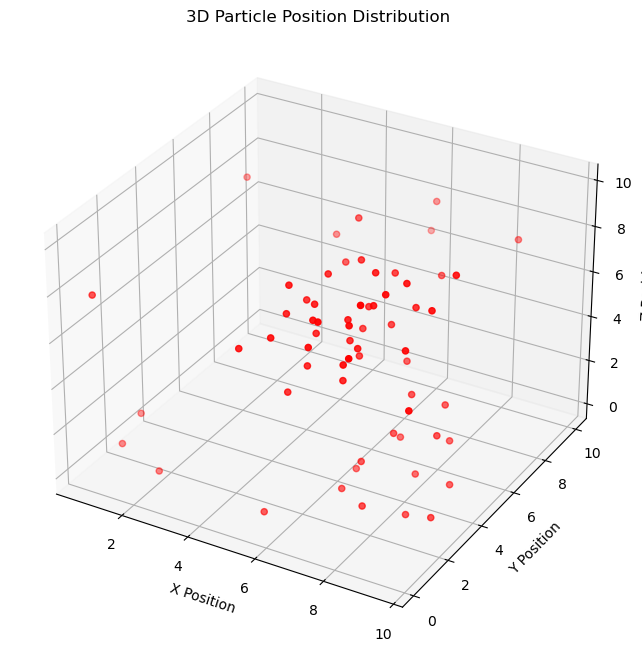

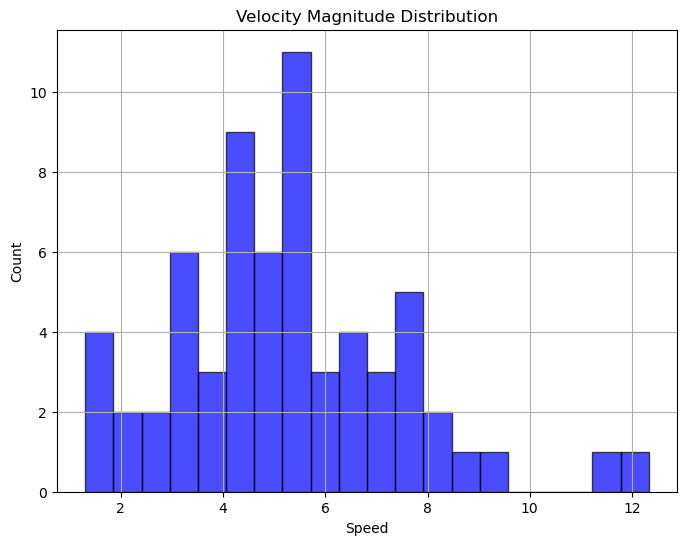

In [74]:
#print(v)
fig1 = plt.figure(figsize=(10, 8))
ax = fig1.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='red', marker='o')
ax.set_title("3D Particle Position Distribution")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
plt.show()   

speeds = np.linalg.norm(v, axis=1)  # 每个粒子的速度大小
fig2 = plt.figure(figsize=(8, 6))
plt.hist(speeds, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Velocity Magnitude Distribution")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.grid(True)
plt.show()
            
        
        

Computed Temperature: T = 10.848


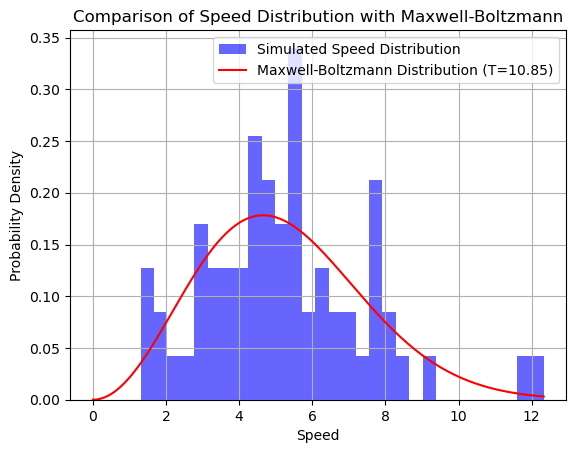

In [72]:
#玻尔兹曼分布部分偷懒让GPT写了。上面主程序自己写的

from scipy.stats import maxwell
# Function to calculate the instantaneous temperature
def compute_temperature(velocities, m=1.0):
    N = len(velocities)
    kinetic_energy = 0.5 * m * np.sum(np.linalg.norm(velocities, axis=1) ** 2)
    T = (2 / 3) * kinetic_energy / N  # Temperature from kinetic energy
    return T

# Function to plot speed distribution and compare with Boltzmann
def plot_velocity_distribution(velocities):
    # Compute speeds from velocity vectors
    speeds = np.linalg.norm(velocities, axis=1)
    
    # Calculate temperature
    T = compute_temperature(velocities)
    print(f"Computed Temperature: T = {T:.3f}")
    
    # Histogram of speeds
    plt.hist(speeds, bins=30, density=True, alpha=0.6, color='blue', label="Simulated Speed Distribution")
    
    # Generate Maxwell-Boltzmann distribution
    m = 1.0  # Mass of particle
    k_B = 1.0  # Boltzmann constant (assume normalized units)
    sigma = np.sqrt(k_B * T / m)
    s = np.linspace(0, np.max(speeds), 200)
    boltzmann_pdf = maxwell.pdf(s, scale=sigma)
    
    # Overlay Boltzmann distribution
    plt.plot(s, boltzmann_pdf, 'r-', label=f"Maxwell-Boltzmann Distribution (T={T:.2f})")
    plt.xlabel("Speed")
    plt.ylabel("Probability Density")
    plt.title("Comparison of Speed Distribution with Maxwell-Boltzmann")
    plt.legend()
    plt.grid()
    plt.show()

# Example Usage: Pass final velocities
plot_velocity_distribution(v)